In [1]:
# Add the parent directory to the path so that we can import the necessary modules
%cd ..

/home/vvrbeast/Desktop/Giannis/Code/SPVD


In [2]:
import torch
import torch.nn as nn
import numpy as np
from datasets.shapenet_pointflow import ShapeNet15kPointClouds
from datasets.utils import NoiseSchedulerDDPM
from torchsparse.utils.quantize import sparse_quantize
from torchsparse import SparseTensor

from torch.utils.data import DataLoader
from pclab.utils import DataLoaders
from torchsparse.utils.collate import sparse_collate_fn

from pclab.learner import *

from functools import partial
from utils.visualization import quick_vis_batch
vis_batch = partial(quick_vis_batch, x_offset = 8, y_offset=8)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
class ShapaNet15kNoisySparseSuperRes(ShapeNet15kPointClouds):

    def __init__(self, root_dir='./data/ShapeNetCore.v2.PC15k', categories=['chair'], pres=1e-5, #, 'car', 'airplane', 'table', 'bag'
                 noise_params={'beta_min':0.0001 ,'beta_max':0.02 , 'n_steps':1000},
                 high_res = 2048, low_res = 1024,
                 split='train',
                 random_subsample=False):
        super().__init__(root_dir=root_dir,
                 categories=categories,
                 tr_sample_size=high_res, 
                 te_sample_size=low_res, # no using this
                 split=split, scale=1., normalize_per_shape=False,
                 normalize_std_per_axis=False,
                 random_subsample=random_subsample)

        self.high_res, self.low_res = high_res, low_res
        self.pres = pres
        self.noise_scheduler = NoiseSchedulerDDPM(beta_min=noise_params['beta_min'],
                                                  beta_max=noise_params['beta_max'],
                                                  n_steps =noise_params['n_steps'])

    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)

        # get original points
        pts = res['train_points']

        # add noise to points
        noisy_pts, t, noise = self.noise_scheduler(pts)

        # keep the 'low_res_size' points without noise
        real_pts = pts[:self.low_res]
        noisy_pts = noisy_pts[self.low_res:]
        all_pts = torch.cat([real_pts, noisy_pts], dim=0)
        # create a mask to points at real points
        mask = torch.ones(len(all_pts), dtype=torch.bool)
        mask[self.low_res:] = False

        # turn to numpy to pass through sparse_quantize #TODO: Use GPU quantize
        all_pts = all_pts.numpy()

        # calculate sparse coordinates
        coords = all_pts - np.min(all_pts, axis=0, keepdims=True)
        coords, indices = sparse_quantize(coords, self.pres, return_index=True)

        # back to torch tensors
        coords = torch.tensor(coords, dtype=torch.int)
        all_pts = torch.tensor(all_pts)
        all_pts = torch.cat([all_pts, mask.unsqueeze(-1)], dim=-1) # add the information of which points are from the original pc
        feats = all_pts[indices]
        noise = noise[indices]
        mask = mask[indices]
        
        # to sparse tensors
        noisy_pc = SparseTensor(coords=coords, feats=feats)
        
        return {
            'noisy_pc':noisy_pc,
            't': t,
            'noise': noise,
            'mask': mask
        }


        

In [4]:
path = '/home/vvrbeast/Desktop/Giannis/Data/ShapeNetCore.v2.PC15k'

tr_dataset = ShapaNet15kNoisySparseSuperRes(root_dir=path, low_res=512, split='train')
vl_dataset = ShapaNet15kNoisySparseSuperRes(root_dir=path, low_res=512, split='val')

tr_dl = DataLoader(tr_dataset, batch_size=32, collate_fn=sparse_collate_fn, drop_last=True, shuffle=True)
vl_dl = DataLoader(vl_dataset, batch_size=32, collate_fn=sparse_collate_fn, drop_last=True, shuffle=True)

dls = DataLoaders(tr_dl, vl_dl)

(1, 1, 1)
Total number of data:4612
Min number of points: (train)2048 (test)512
(1, 1, 1)
Total number of data:662
Min number of points: (train)2048 (test)512


In [5]:
batch = next(iter(tr_dl))
batch.keys()

dict_keys(['noisy_pc', 't', 'noise', 'mask'])

In [6]:
batch_real = batch['noisy_pc'].F[batch['mask'].view(-1)][:, :3].reshape(32, -1, 3)
batch_real.shape

torch.Size([32, 512, 3])

In [7]:
vis_batch(batch_real)

# Train Prep

In [8]:
class DDPMCB(Callback):

    def before_batch(self, learn):
        pts = learn.batch['noisy_pc']
        t = torch.tensor(learn.batch['t'])
        inp = (pts, t)
        target = learn.batch['noise'], learn.batch['mask'].view(-1)
        learn.batch = (inp, target)

In [9]:
from pclab.utils import def_device
import fastcore.all as fc
from typing import Mapping
from copy import copy
from torcheval.metrics import Mean
from utils.callbacks import GradientClipCB
from utils.callbacks import CheckpointCB
import torchsparse

def to_device(x, device=def_device):
    if isinstance(x, (torch.Tensor, torchsparse.SparseTensor)): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

class DeviceCBSparse(Callback):
    order = DDPMCB.order + 1
    def __init__(self, device=def_device): fc.store_attr()
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'): learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, device=self.device)


class LossCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        x,y,*_ = learn.batch
        #for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=2)

In [10]:
class CustomMSELoss(nn.Module):

    def __init__(self):
        super().__init__()

        self.loss_fn = nn.MSELoss()
    
    def forward(self, preds, target):

        noise, mask = target

        # calculate loss only for the noisy points
        preds = preds[~mask, :3]
        
        noise = noise.view(-1, 3)[~mask]

        return self.loss_fn(preds, noise)

# Training 

In [11]:
from models.spvd import SPVUnet
get_model = partial(SPVUnet, point_channels=4, 
                    down_blocks = [[(64, 128, 192, 256, 256), (True, True, True, False), (None, None, None, None)]], # only one point skip connection during downsampling
                    up_blocks   = [[(256, 256, 192), (True, True), (None, None), (3, 3)], 
                                    [(192, 128, 64), (True, False), (None, None), (3, 3)]])

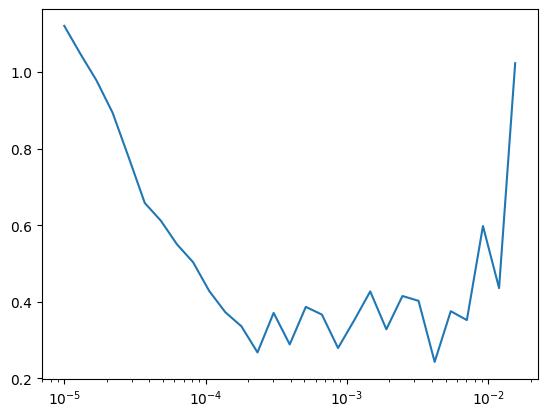

In [12]:
ddpm_cb = DDPMCB()
model = get_model()
learn = TrainLearner(model, dls, CustomMSELoss(), cbs=[ddpm_cb, DeviceCBSparse(), GradientClipCB()], opt_func=torch.optim.Adam)
learn.lr_find(max_mult=3)

In [13]:
lr = 0.0001 
epochs = 20

model = get_model()

# scheduler
total_steps = epochs * len(dls.train)
sched = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, total_steps = total_steps)

# Callbacks
ddpm_cb = DDPMCB()
checkpoint_cb = CheckpointCB(1000, 'SuperRes', run_params={'msg':model.msg})
cbs = [ddpm_cb, DeviceCBSparse(), ProgressCB(plot=False), LossCB(), GradientClipCB(), checkpoint_cb, BatchSchedCB(sched)]

learn = TrainLearner(model, dls, CustomMSELoss(), lr=lr, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(epochs)

loss,epoch,train
0.486,0,train
0.301,0,eval
0.270,1,train
0.233,1,eval
0.245,2,train
0.234,2,eval
0.219,3,train
0.234,3,eval
0.234,4,train
0.222,4,eval


KeyboardInterrupt: 

# Test Super-Resolution

In [2]:
#export
import torch
from torchsparse import SparseTensor
from utils.schedulers import SchedulerBase, SchedulingStrategy, DDPM
from abc import abstractmethod
from models.sparse_utils import batch_sparse_quantize_torch

ModuleNotFoundError: No module named 'utils'

For completion a tensor with 4 features is required
- `points[..., :3]` : x,y,z coordinates
- `points[..., -1]` : Indicates if the point is from the original point cloud or if it padded noise. 

In [87]:
#export
class CompletionScheduler(SchedulerBase):

    @abstractmethod
    def get_pc(self, x_t, shape):
        pass

    @abstractmethod
    def pad_noise(x0, n_points):
        pass
    
    @torch.no_grad()
    def complete(self, x0, model, n_points, emb=None, save_process=False):
        # get the model device
        device = next(model.parameters()).device

        # take x_0 to device
        x0 = x0.to(device)

        shape = torch.Size((x0.shape[0], n_points, x0.shape[-1] + 1))
        
        # pad noise to point cloud
        x_t = self.pad_noise(x0, n_points)
        if save_process: preds = [self.get_pc(x_t, shape)] 
        
        for i, t in enumerate(self.strategy.steps):
            x_t = self.sample_step(model, x_t, t, i, emb, shape, device)
            if save_process: preds.append(self.get_pc(x_t, shape))
        
        return preds if save_process else self.get_pc(x_t, shape)

In [146]:
#export
class SparseCompletionScheduler(CompletionScheduler):

    def __init__(self, strategy:SchedulingStrategy, save_process=False, pres=1e-5):
        super().__init__(strategy, save_process)
        self.pres = pres

    def pad_noise(self, x0, n_points):
        B, N, F = x0.shape
        num_pad = n_points - N
        noise = torch.randn(B, num_pad, F).to(x0.device)
        padded_pc = torch.cat([x0, noise], dim=1)

        mask = torch.zeros(B, n_points, 1).to(x0.device)
        mask[:, :N] = 1
        # print(N)
        # print(x0.shape)
        # print(n_points)
        # print(mask.sum())
        # print(mask.shape)

        padded_pc = torch.cat([padded_pc, mask], dim=-1)

        return self.torch2sparse(padded_pc, padded_pc.shape)       

    def update_rule(self, x_t, noise_pred, t, i, shape, device):
        mask = x_t.F[:, -1].bool()

        # print(mask.sum())
        
        x_t_new = self.strategy.update_rule(x_t.F[:, :3], noise_pred[:, :3], t, i, shape, device)
        
        x_t = x_t.F[:, :3]* mask.unsqueeze(-1) + x_t_new * ~mask.unsqueeze(-1)
        
        x_t = torch.cat([x_t, mask.unsqueeze(-1)], dim=-1)

        return self.torch2sparse(x_t, shape).to(device)

    def get_pc(self, x_t, shape):
        return x_t.F.detach().cpu().reshape(shape)[:, :, :3]

In [147]:
#export
class SparseCompletionSchedulerGPU(SparseCompletionScheduler):

    def torch2sparse(self, pts:torch.Tensor, shape):
        pts = pts.reshape(shape)
        
        coords = pts[..., :3] # In case points have additional features
        coords = coords - coords.min(dim=1, keepdim=True).values
        coords, indices = batch_sparse_quantize_torch(coords, voxel_size=self.pres, return_index=True, return_batch_index=False)
        feats = pts.view(-1, shape[-1])[indices]

        return SparseTensor(coords=coords, feats=feats).to(coords.device)

In [148]:
#export
class DDPMSparseCompletionSchedulerGPU(SparseCompletionSchedulerGPU):
    def __init__(self, beta_min=0.0001, beta_max=0.02, n_steps=1000, mode='linear', sigma='bt', pres=1e-5, save_process=False):
        strategy = DDPM(beta_min=beta_min, beta_max=beta_max, n_steps=n_steps, mode=mode, sigma=sigma)
        super().__init__(strategy, save_process=save_process, pres=pres)

In [149]:
model = get_model().eval().cuda()
model.load_state_dict(torch.load('./checkpoints/SuperRes.pt')['state_dict'])

<All keys matched successfully>

In [175]:
batch = next(iter(vl_dl))
pc = batch['noisy_pc'].F
mask = pc[:, -1].bool()
pc = pc[mask, :3].reshape(32, 512, 3)[:2]
quick_vis_batch(pc, grid=(2, 1), x_offset=8, y_offset= 8)

In [ ]:
def pad(t, np):
    B, N, F = t.shape
    padded = torch.zeros(B, np, F).to(t)
    padded[:, :N, :] = t

    return padded

In [176]:
c = DDPMSparseCompletionSchedulerGPU()

In [181]:
preds = c.complete(pc, model, n_points=4096, save_process=False)

In [182]:
vis = torch.cat([preds, pad(pc, 4096)], dim=0)

In [184]:
quick_vis_batch(vis, grid=(2, 2), x_offset=8, y_offset= 8)